In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
import pyfd3d.nonuniform_grid as nug
from pyfd3d.constants import *
from pyfd3d.modal_source import *
from pyfd3d.pml import *
from scipy.sparse.linalg import qmr, bicgstab

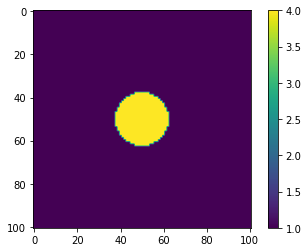

In [45]:
Nz = 210
Npml = np.array([10,10,0])
L0 = 1e-6
## specify slab plane
xrange = yrange = np.array([-0.5,0.5])
zrange = [-1,1];
radius = 0.125
Nx = Ny = 101

N = np.array([Nx,Ny,Nz])

x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[0], zrange[1], Nz)
xx,yy = np.meshgrid(x,y)

slab_plane = 1*np.ones((Nx,Ny))

slab_plane[xx**2+yy**2<radius**2] = 4
plt.imshow(slab_plane)
plt.colorbar()

wvlen = 0.51


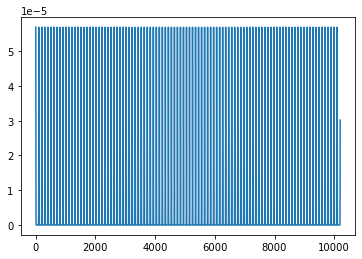

In [30]:
omega = 2*np.pi*C0/(wvlen*L0);
dx = np.diff(xrange)/Nx
dy = np.diff(yrange)/Ny
Sxfi, Sxbi, Syfi, Sybi, Szfi,_ = S_create_3D(omega, [dx, dy, 1],
                                          [Nx, Ny, 1],
                                          [Npml[0], Npml[1],0], 
                                          EPS0, ETA0) 

plt.plot(np.imag(Sxfi.diagonal()))

## mode solve the slab_plane

In [6]:
print(L0, xrange, yrange)

1e-06 [-0.5  0.5] [-0.5  0.5]


In [7]:
TE_op = eigen_2D_slice(L0, wvlen, xrange, yrange, slab_plane, [10,10])


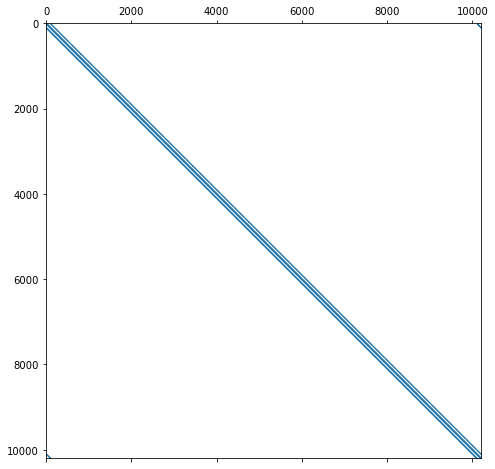

In [8]:
plt.figure(figsize = (8,8));
plt.spy(TE_op, markersize = 0.1)

In [9]:
print(TE_op[0:10, 0:10])

  (0, 1)	(2.4573657695097478e+29-8.071177371020895e+27j)
  (0, 0)	(-1.4169510119349242e+30+6.093796269497016e+28j)
  (1, 0)	(3.2698748947443e+29-1.2394566951282142e+28j)
  (1, 1)	(-1.4767932524153332e+30+6.230993683123719e+28j)
  (1, 2)	(4.413302569734411e+29-1.9446388532469978e+28j)
  (2, 1)	(6.050623626219541e+29-3.124150872444799e+28j)
  (2, 2)	(-2.1575890457731525e+30+1.132379928905327e+29j)
  (2, 3)	(8.440511771837364e+29-5.152750281859961e+28j)
  (3, 2)	(1.200354886679368e+30-8.751406013515773e+28j)
  (3, 3)	(-3.6530067403311426e+30+2.715841189989094e+29j)
  (3, 4)	(1.7441763476843124e+30-1.536010775162666e+29j)
  (4, 3)	(2.5960734026386195e+30-2.7977494586437368e+29j)
  (4, 4)	(-7.273968532285902e+30+8.416965043475846e+29j)
  (4, 5)	(3.9694196236798213e+30-5.3145257713572576e+29j)
  (5, 4)	(6.253646038669204e+30-1.0589190915202616e+30j)
  (5, 5)	(-1.7141821777080188e+31+3.3170201101025536e+30j)
  (5, 6)	(1.0179700232443523e+31-2.2276320372348068e+30j)
  (6, 5)	(1.714258589607271

## specify a target sigma
Don't use 'LM', 'SM' options

In [50]:
%%time
eigenvals, eigenvecs = sp.linalg.eigs(TE_op, k = 10, sigma = 3*omega**2)

CPU times: user 1.4 s, sys: 30.1 ms, total: 1.43 s
Wall time: 195 ms


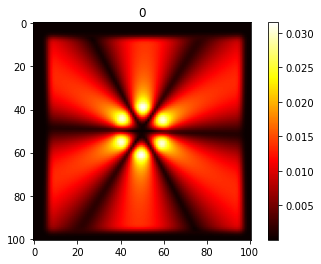

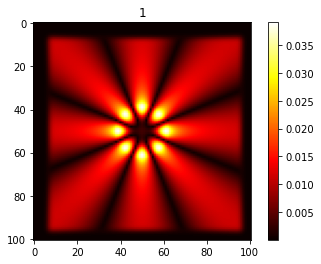

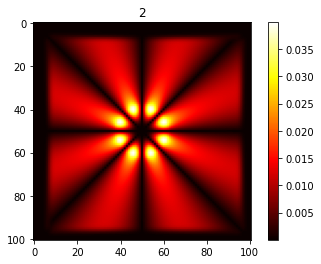

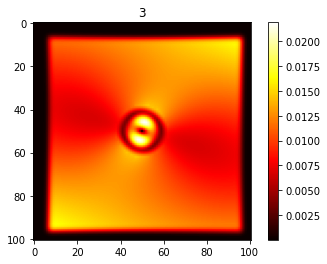

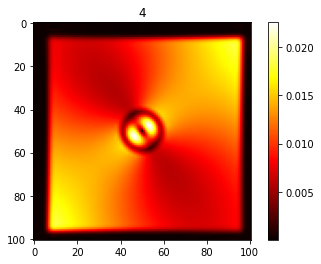

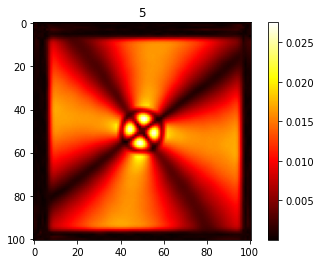

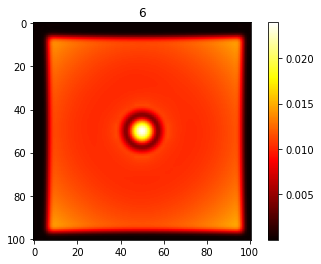

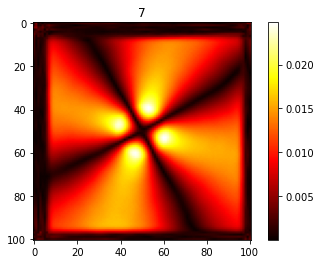

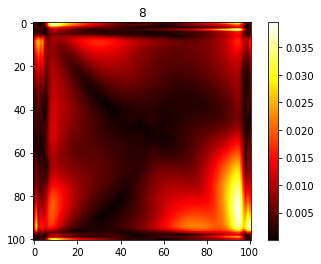

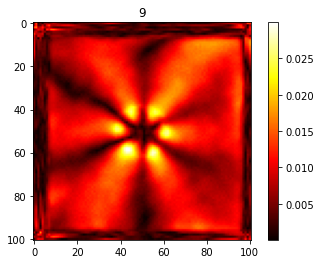

In [53]:
for i in range(eigenvecs.shape[-1]):
    mode_field = np.reshape(eigenvecs[:,i], (Nx,Ny), order = 'F')
    #plt.imshow(np.real(mode_field), cmap = 'RdBu')
    #plt.clim(-0.5e-1, 0.5e-1)
    plt.imshow(np.abs(mode_field), cmap = 'hot')
    plt.title(i)
    plt.colorbar()
    plt.show()

In [24]:
print(eigenvals)

[ 3.71447464e+16-3.52564959e+16j -8.20983881e+28+2.89116737e+29j
 -2.87351323e+29+1.45180582e+29j -1.25608724e+29+3.16224565e+29j
 -4.02269278e+29+2.25714553e+29j -3.95781001e+29+4.37109196e+29j
 -5.60769821e+29+2.64177919e+29j -8.06941113e+29-4.62109433e+28j
 -5.19820988e+29+4.27468129e+29j -7.38273237e+29+2.11124201e+29j]


In [47]:
## integrate slab structure into 3D grid
eps_r = np.ones((Nx,Ny,Nz))
N = [Nx,Ny,Nz]

In [48]:
print(eps_r.shape)
for k in range(0,Nz):
    eps_r[:,:,k] = slab_plane

(101, 101, 210)


## use one of the modes as an excitation source for the waveguide

In [61]:
Jz = np.zeros(N).astype('complex'); 
Jy = np.zeros(N).astype('complex'); 
Jx = np.zeros(N).astype('complex'); 

Jx[:,:,35] = np.reshape(eigenvecs[:,2],(Nx,Ny));

omega_squared = np.real(eigenvals[2])
omega = omega_squared**0.5
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


In [62]:
c0 = 3e8

In [66]:
%%time
wvlen = 2*np.pi*c0/omega/L0;
print(wvlen)
print(L0, xrange, yrange, zrange)

A,b, Ch = fd3d.curlcurlE(L0, 
                         wvlen, 
                         xrange, 
                         yrange, 
                         zrange, 
                         eps_r_tensor_dict, 
                         JCurrentVector,Npml, 
                         s = -1
                        )

0.2597826394788211
1e-06 [-0.5  0.5] [-0.5  0.5] [-1, 1]
(6426630,)


In [67]:
%%time
x, info = bicgstab(A,b, maxiter = 2000);
print(info)

2000
CPU times: user 2h 19min 20s, sys: 2min 12s, total: 2h 21min 33s
Wall time: 22min 3s


In [74]:
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

# Hx =  y[0:M].reshape(N, order = 'F')
# Hy =  y[M:2*M].reshape(N, order = 'F')
# Hz =  y[2*M:].reshape(N, order = 'F')


/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_41910/1324033842.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


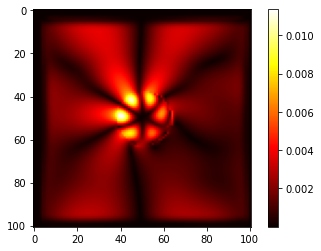

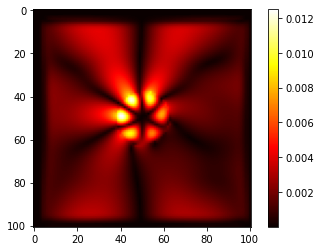

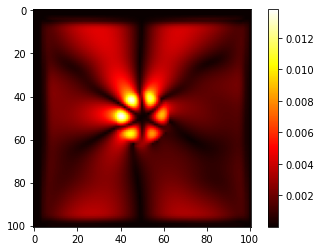

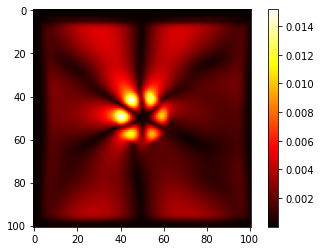

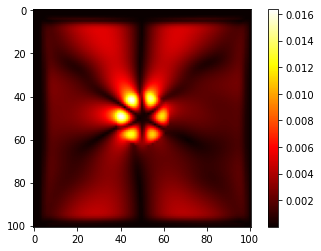

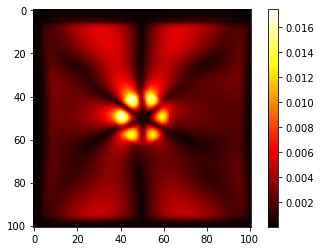

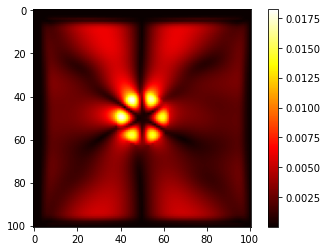

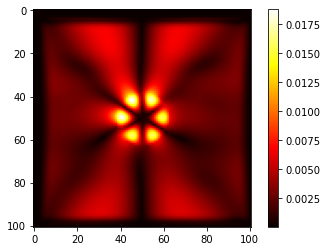

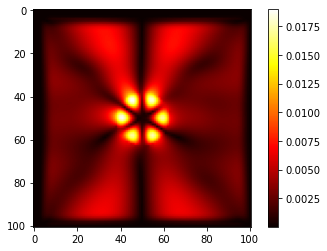

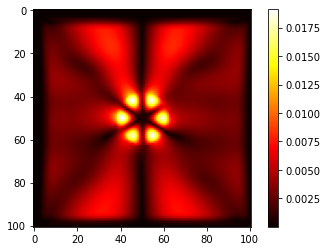

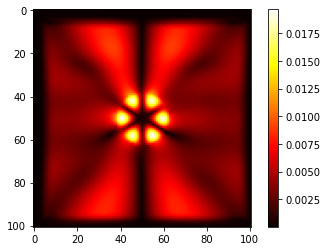

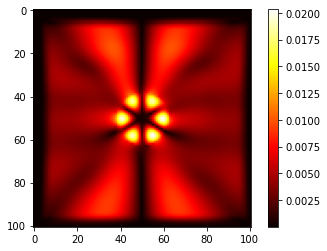

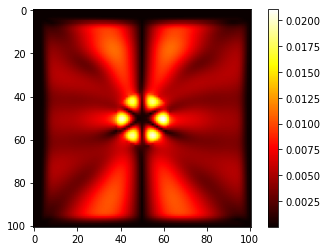

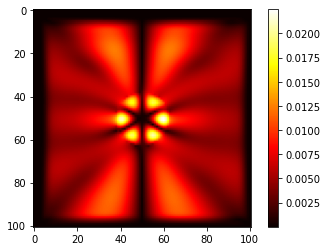

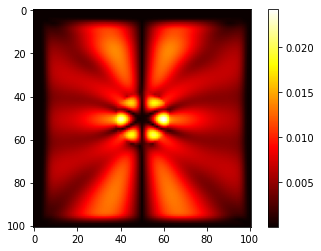

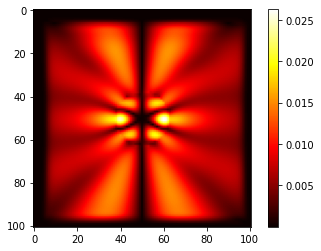

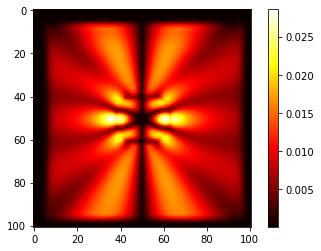

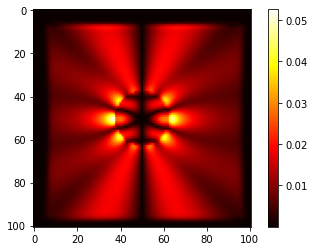

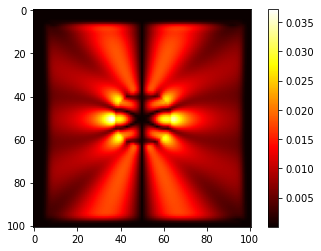

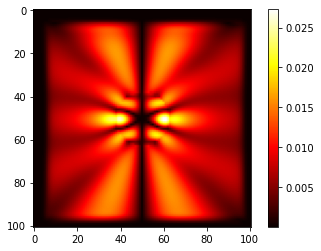

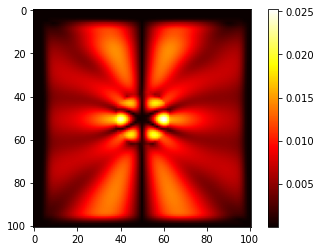

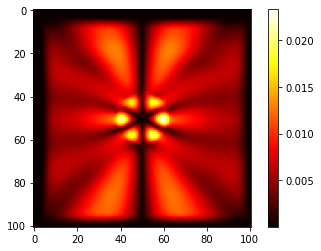

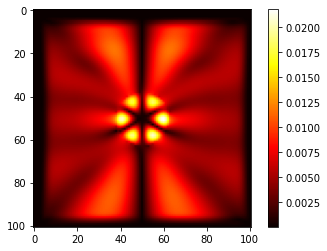

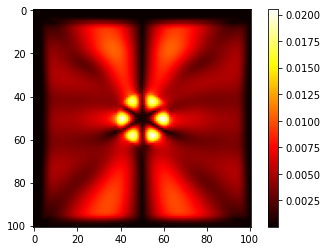

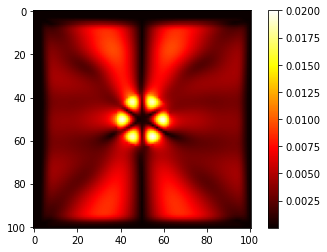

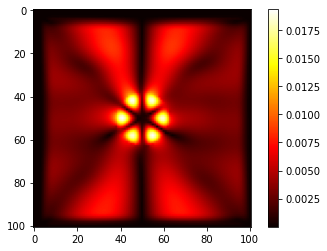

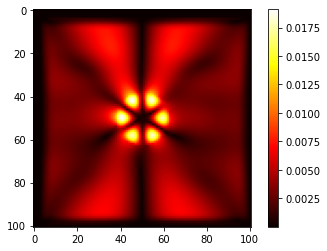

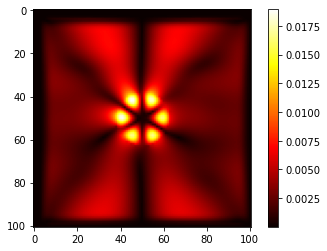

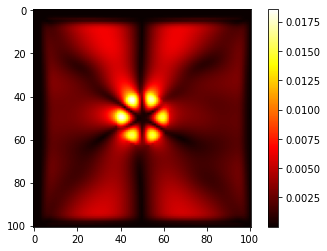

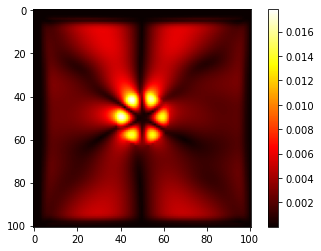

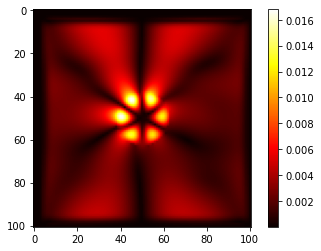

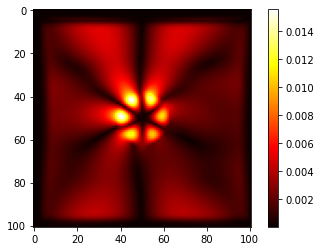

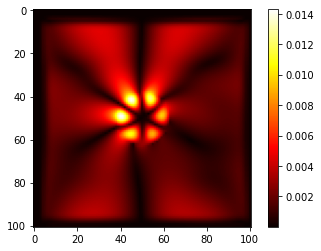

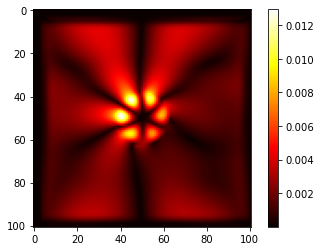

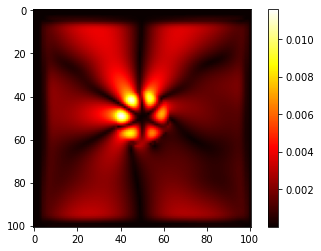

In [ ]:
for i in range(0,N[-1],2):
    plt.figure()
    plt.imshow(np.abs(Ez[:,:,i]), cmap = 'hot')
    #plt.clim(0,0.5e-2)
    plt.colorbar()

/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_41910/1821804242.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


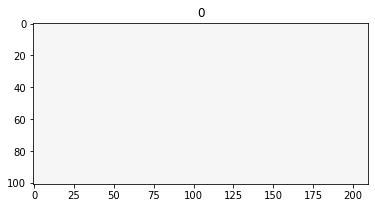

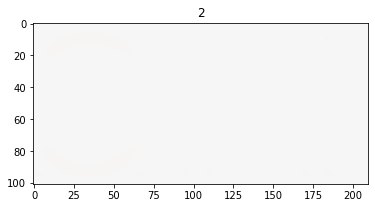

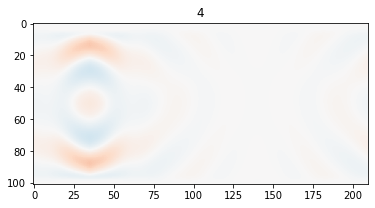

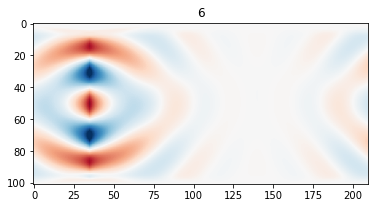

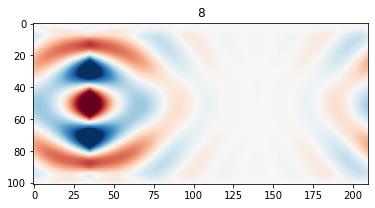

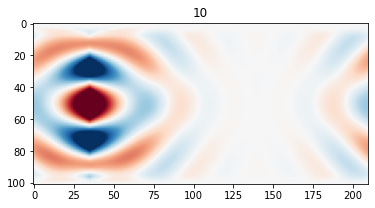

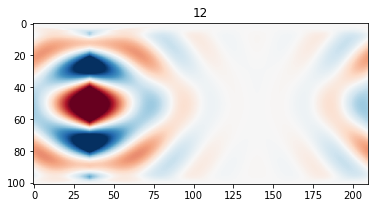

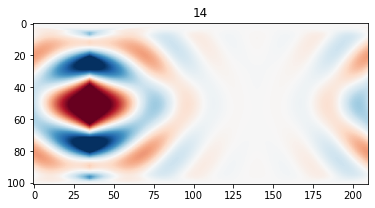

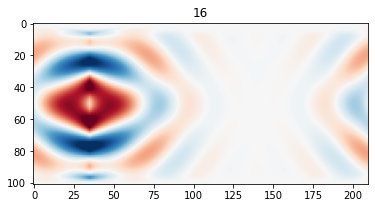

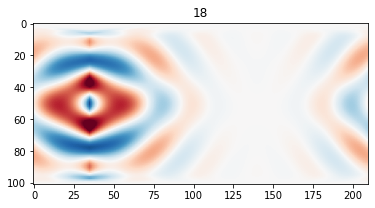

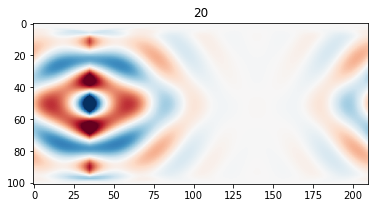

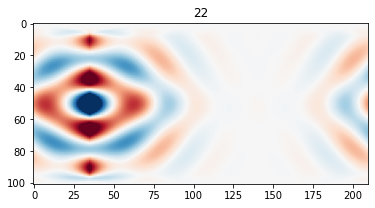

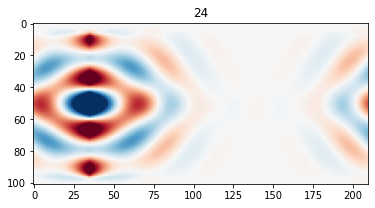

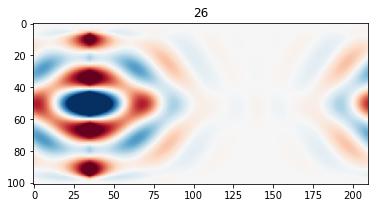

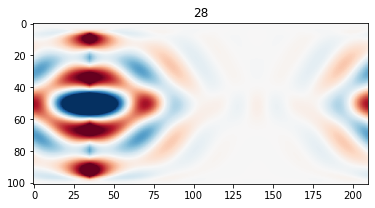

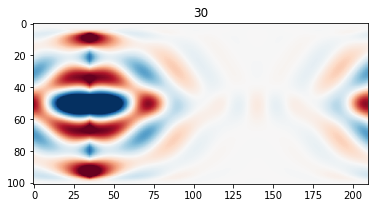

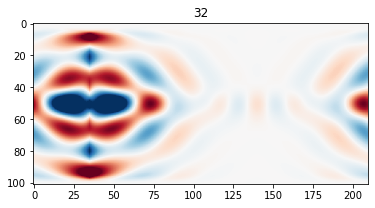

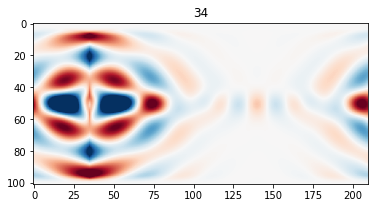

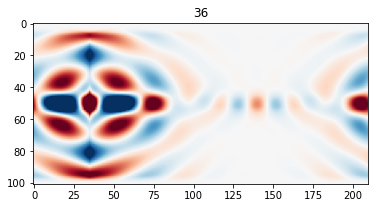

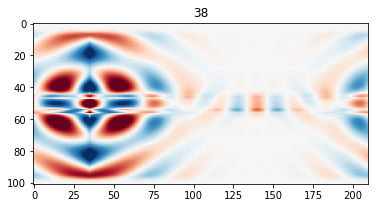

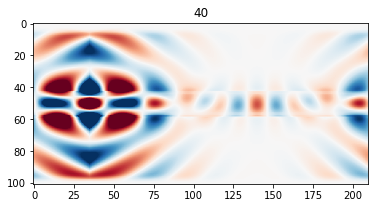

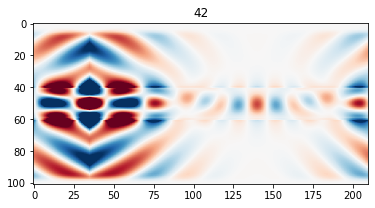

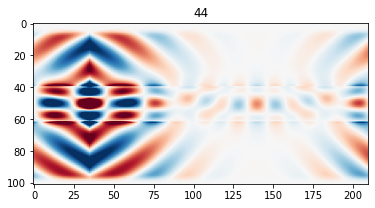

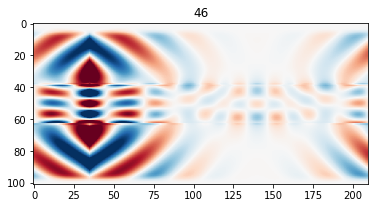

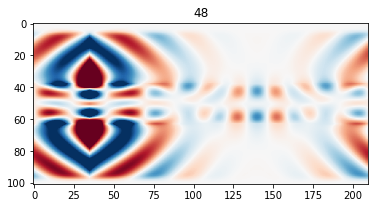

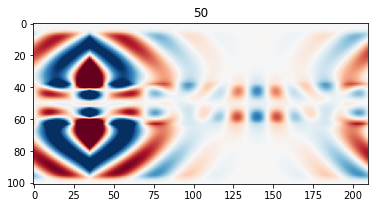

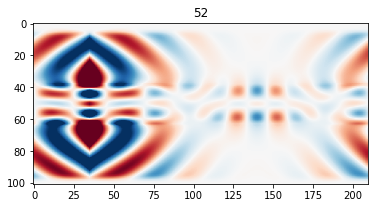

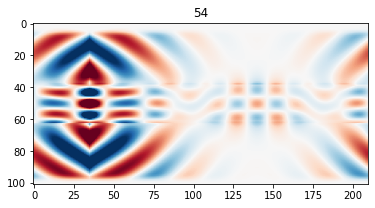

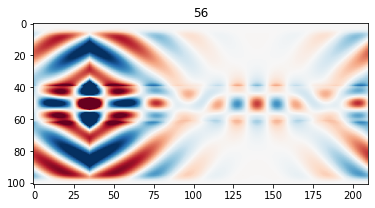

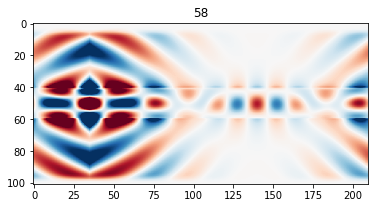

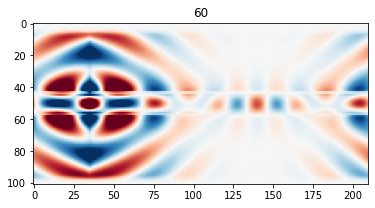

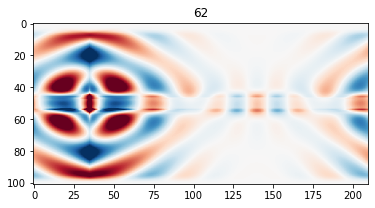

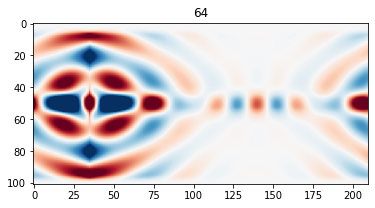

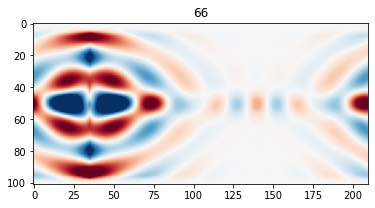

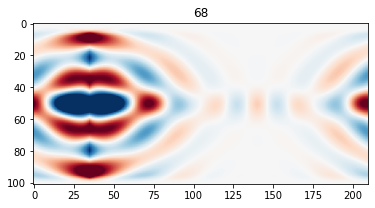

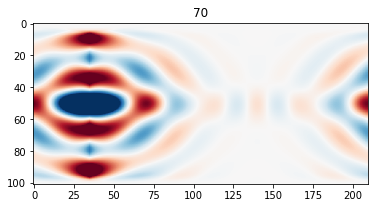

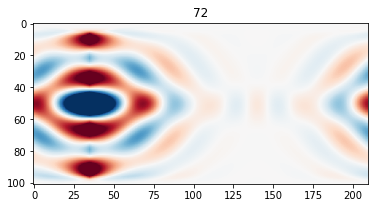

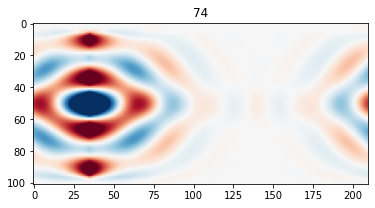

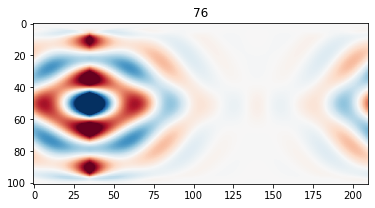

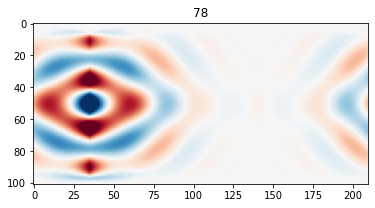

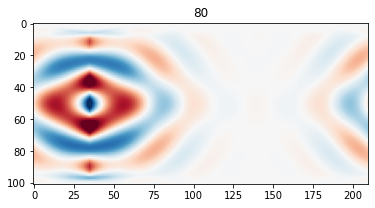

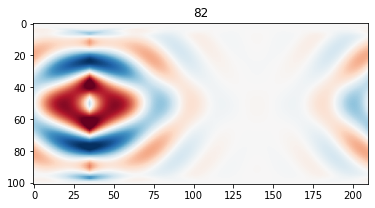

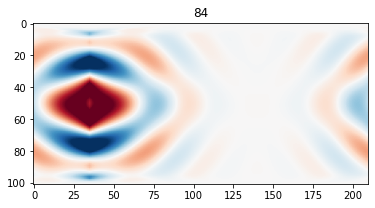

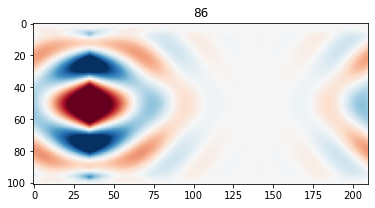

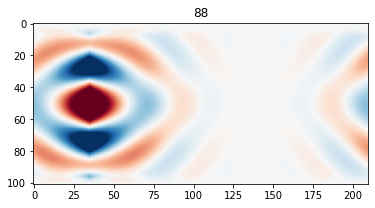

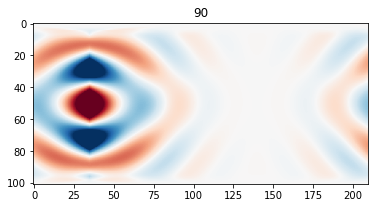

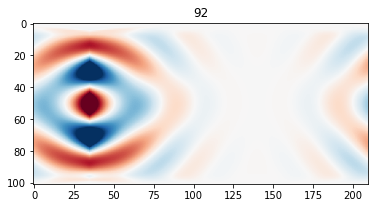

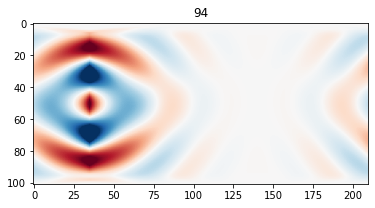

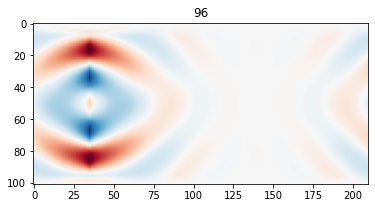

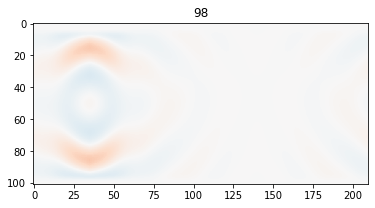

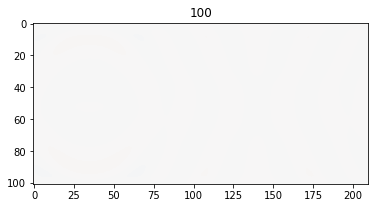

In [80]:
for i in range(0,N[0],2):
    plt.figure()
    ax = plt.subplot(111)
    plt.imshow(np.real(Ey[:,i,:]), cmap = 'RdBu')
    plt.clim(-1e-2, 1e-2)
    ax.set_aspect('equal')
    #plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')
    #plt.clim(-0.1e-2,0.1e-2)
    plt.title(i)
    #plt.colorbar()
#     if(i == 50):
#         plt.savefig('../img/3d_waveguide_abs_slice.png',dpi =300)
    